In [78]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import scipy.sparse as sp
import time
import itertools
import scipy
import cvxpy as cp



class Genetic_Algorithm:
    def __init__(self, beta, img1, img2):
        
        self.beta = beta
        self.N = img1.shape[0]
        self.M = img2.shape[0]
        self.img1 = img1.flatten()
        self.img2 = img2.flatten()
        self.b_eq = np.concatenate((self.img1, self.img2))
        self.non_zero_indices = []
        
        start = time.time()
        print("initializing omega...")
        self.current_gamma, self.active_indices = self.initialize_omega()
        print("omega initialized in %5.3f. s" %(time.time()-start))
        
        start = time.time()
        print("initializing cost vector...")
        self.current_cost_vector = self.get_cost(self.active_indices)
        print("cost vector initialized in %5.3f. s" %(time.time()-start))
        start = time.time()
        print("initializing full model...")
        self.current_gamma, self.constraints_RMP, self.current_kantorovich_u, self.current_kantorovich_v = self.initialize_model()
        print("full model initialized in %5.3f. s" %(time.time()-start))

        #stats
        self.cost = []
        self.time_child = []
        self.children_sampled = []
        self.time_model = []
        
    def initialize_model(self):
        indices_row = np.array([])
        indices_col = np.array([])

        for indices in range(self.N**2):
            gamma_indices = np.where(self.active_indices.transpose()[0] == indices)[0]
            indices_row = np.concatenate((indices_row, gamma_indices))
            indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*indices))

        for indices in range(self.M**2):
            gamma_indices = np.where(self.active_indices.transpose()[1] == indices)[0]
            indices_row = np.concatenate((indices_row, gamma_indices))
            indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*(indices+self.N**2)))

        A_eq = sp.csr_matrix((np.ones(len(indices_col)), (indices_col, indices_row)), shape=( self.N**2 + self.M**2, len(self.active_indices)))
        gamma = cp.Variable(len(self.current_cost_vector))
        objective = cp.Minimize(self.current_cost_vector @ gamma)
        constraints = [A_eq @ gamma == self.b_eq, gamma >= 0]
        prob = cp.Problem(objective, constraints)
        gamma.value = self.current_gamma
        prob.solve(warm_start = True, solver=cp.GUROBI)
        primal_solution = gamma.value
        dual_solution = -constraints[0].dual_value
        return primal_solution, A_eq, dual_solution[:self.N**2], dual_solution[self.N**2:]

    def barycentric_distance(self, x, y):
        # mean squared deviation from the classical barycenter of the xi
        #rescale x and y to be in [0,1]
        x = x / self.N
        y = y / self.N
        barycenter = x * 0.5 + y * 0.5
        barycenter = 0.5 * np.sum((x - barycenter) ** 2, axis=0) + 0.5 * np.sum(
            (y - barycenter) ** 2, axis=0)
        return barycenter

    def get_cost(self, vector):
        #for each pair of active pixels, compute the cost of moving the first pixel to the second

        indices_img1 = np.array(np.unravel_index(vector.transpose()[0], (self.N, self.N)))
        indices_img2 = np.array(np.unravel_index(vector.transpose()[1], (self.M, self.M)))
        cost_vector = self.barycentric_distance(indices_img1, indices_img2)

        return cost_vector

    def compute_gain(self,cost, children):
        return self.current_kantorovich_u[children.transpose()[0]] + self.current_kantorovich_v[children.transpose()[1]] - cost

    def find_best_child(self):
        parent = self.non_zero_indices.copy().transpose()

        parent_2 = parent.copy()
        parent[1] = np.random.randint(0, self.N**2, size=len(parent[1]))
        children = parent.transpose()
        gain = self.compute_gain(self.get_cost(children), children)
        best_gain = np.max(gain)
        best_child = children[np.argmax(gain)]
        if best_gain > 0:
            return best_gain, best_child
        else:
            parent_2[0] = np.random.randint(0, self.N**2, size=len(parent[1]))
            children = parent_2.transpose()
            gain = self.compute_gain(self.get_cost(children), children)
            best_gain = np.max(gain)
            best_child = children[np.argmax(gain)]
        return best_gain, best_child

    
    def get_single_cost(self, child):
        i = np.array(np.unravel_index(child[0], (self.N, self.N)))
        j = np.array(np.unravel_index(child[1], (self.M, self.M)))
        return self.barycentric_distance(i,j)

    def initialize_omega(self):
        #the north west rule is used to initialise omega
        #we start with the first pixel of each image
        omega = [[0,0]]
        i, j = 0, 0
        b = np.array([self.img1[0], self.img2[0]])
        gamma = []
        current_gamma = [min(b[0], b[1])]
        while i < self.N**2-1 and j < self.M**2-1:
            gamma = min(b[0], b[1])
            b = b - gamma
            if np.argmin(b) == 0:
                i += 1
                b[0] += self.img1[i]
                omega.append([i, j])
                current_gamma.append(gamma)
            else:
                j += 1
                b[1] += self.img2[j]
                omega.append([i, j])
                current_gamma.append(gamma)
        while i < self.N**2-1:
            i += 1
            omega.append([i, j])
            current_gamma.append(0)
        while j < self.M**2-1:
            j += 1
            omega.append([i, j])
            current_gamma.append(0)


        return np.array(current_gamma), np.array(omega)
    
    def run(self, max_iter):
        for _ in tqdm(range(max_iter)):

            start = time.time()
            self.non_zero_indices = self.active_indices[np.nonzero(self.current_gamma)]

            sample = 0
            #divide the non zero indices into chunks of size chunk_size

            while True:
                best_gain, best_child = self.find_best_child()
                sample += len(self.non_zero_indices)
                if best_gain > 0:
                    break
            if best_gain<=0:
                break
           
            self.children_sampled.append(sample)
            self.time_child.append(time.time() - start)
            self.active_indices = np.vstack((self.active_indices, best_child))
            self.current_cost_vector = np.append(self.current_cost_vector, self.get_single_cost(best_child))
            self.current_gamma = np.append(self.current_gamma, 0)
            if self.active_indices.shape[0] > self.beta*(self.N**2 + self.M**2):
                #delete first (beta-1)*(N^2 + M^2) 0 entries
                zero_indices = np.where(self.current_gamma == 0)[:beta]
                self.active_indices = np.delete(self.active_indices, zero_indices, axis=0)
                self.current_cost_vector = np.delete(self.current_cost_vector, zero_indices)
                self.current_gamma = np.delete(self.current_gamma, zero_indices)
                self.current_gamma, self.constraints_RMP, self.current_kantorovich_u, self.current_kantorovich_v = self.initialize_model()
                continue
            self.solve_model()





    def solve_model(self):
        start = time.time()

        A_eq = self.constraints_RMP

        #add a column to A_eq that has a 1 in the coordinate corresponding to the new  child

        child_mu, child_nu = self.active_indices[-1]
        A_col = np.zeros(self.N**2 + self.M**2)
        A_col[child_mu] = 1
        A_col[self.N**2 + child_nu] = 1


        #add the column horizontally
        A_eq = sp.hstack((A_eq, A_col.reshape(-1,1)))

        self.constraints_RMP = A_eq
        gamma = cp.Variable(len(self.current_cost_vector))
        prob = cp.Problem(cp.Minimize(self.current_cost_vector @ gamma), [A_eq @ gamma == self.b_eq, gamma >= 0])
        gamma.value = self.current_gamma

        prob.solve(warm_start=True, solver=cp.GUROBI, verbose=False)

        primal_solution = gamma.value
        dual_solution = -prob.constraints[0].dual_value
        self.cost.append(prob.value)
        self.time_model.append(time.time()-start)
        self.current_gamma = primal_solution
        self.current_kantorovich_u = dual_solution[:self.N**2]
        self.current_kantorovich_v = dual_solution[self.N**2:]

    def get_mean(self, par):
        indices_x = np.unravel_index(self.active_indices.transpose()[0], (img1.shape[0], img1.shape[0]))
        indices_y = np.unravel_index(self.active_indices.transpose()[1], (img2.shape[0], img2.shape[0]))
        mean = (par * indices_x[0] + (1 - par) * indices_y[0]).astype('int'), (
                    par * indices_x[1] + (1 - par) * indices_y[1]).astype('int')
        #transform the mean back to a 1d index
        mean = np.ravel_multi_index(mean, (img1.shape[0], img1.shape[0]))
        #check how many coordinates of mean and indices_x are the same
        gamma = sp.csr_matrix((self.current_gamma, (self.active_indices.transpose()[0], mean)),
                              shape=(img1.shape[0] ** 2, img2.shape[0] ** 2))
        return gamma.todense().transpose().dot(normalized_img1.flatten()).reshape(img1.shape[0], img1.shape[0])

    def reduce(self):
        non_zero_indices = np.where(self.current_gamma != 0)[0]
        self.active_indices = self.active_indices[non_zero_indices]
        self.current_cost_vector = self.current_cost_vector[non_zero_indices]
        self.current_gamma = self.current_gamma[non_zero_indices]

    def plot(self):
        plt.close()
        fig, axs = plt.subplots(2, 6)
        axs[0][0].imshow(self.get_mean(1), cmap='gray')
        axs[0][1].imshow(self.get_mean(0.95), cmap='gray')
        axs[0][2].imshow(self.get_mean(0.9), cmap='gray')
        axs[0][3].imshow(self.get_mean(0.8), cmap='gray')
        axs[0][4].imshow(self.get_mean(0.7), cmap='gray')
        axs[0][5].imshow(self.get_mean(0.6), cmap='gray')
        axs[1][0].imshow(self.get_mean(0.5), cmap='gray')
        axs[1][1].imshow(self.get_mean(0.4), cmap='gray')
        axs[1][2].imshow(self.get_mean(0.3), cmap='gray')
        axs[1][3].imshow(self.get_mean(0.2), cmap='gray')
        axs[1][4].imshow(self.get_mean(0.1), cmap='gray')
        axs[1][5].imshow(self.get_mean(0), cmap='gray')
        plt.show()
 

In [84]:
if __name__ == '__main__':
    lambda_parameter = 0.5
    #generate values between 0 and 1
    #load images
    path_img1 = "dolphin.jpg"
    path_img2 = "star.jpg"
    img1 = np.array(Image.open(path_img1).convert('L'))
    #switch black and white
    img2 = np.array(Image.open(path_img2).convert('L'))
    img_coordinates = np.array([[(i, j) for i in range(img1.shape[0])] for j in range(img2.shape[0])])

    img_coordinates = img_coordinates.reshape(img1.shape[0]*img2.shape[0], 2)
    normalized_img1 = img1 / 255
    normalized_img2 = img2 / 255
    normalized_img1 = 1 - normalized_img1
    normalized_img2 = 1 - normalized_img2
    normalized_img1 = (normalized_img1 / np.sum(normalized_img1))*img1.shape[0]
    normalized_img2 = (normalized_img2 / np.sum(normalized_img2))*img2.shape[0]
    beta = 3  # hyperparameter
    ga = Genetic_Algorithm(beta=beta, img1=normalized_img1, img2=normalized_img2)

initializing omega...
omega initialized in 0.470. s
initializing cost vector...
cost vector initialized in 0.003. s
initializing full model...
full model initialized in 10.237. s


In [85]:
ga.run(max_iter=200)
ga.reduce()

 10%|█         | 20/200 [00:33<05:00,  1.67s/it]


KeyboardInterrupt: 

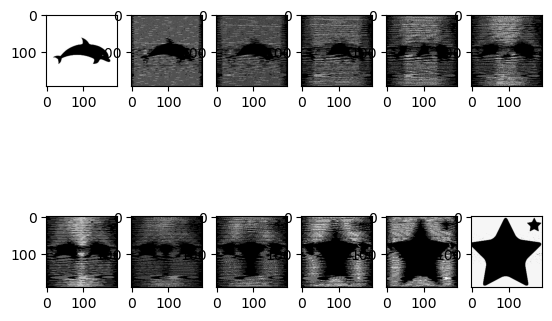

In [86]:
ga.plot()

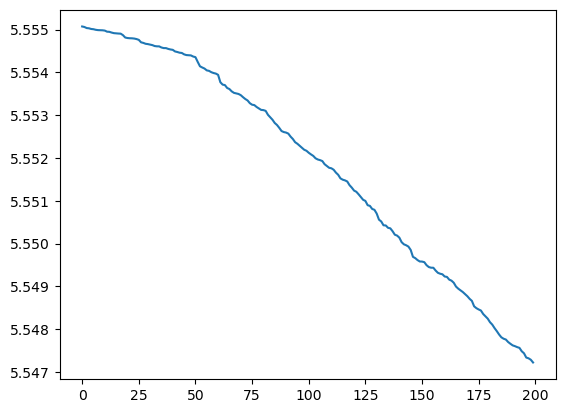

In [68]:
plt.plot(ga.cost)

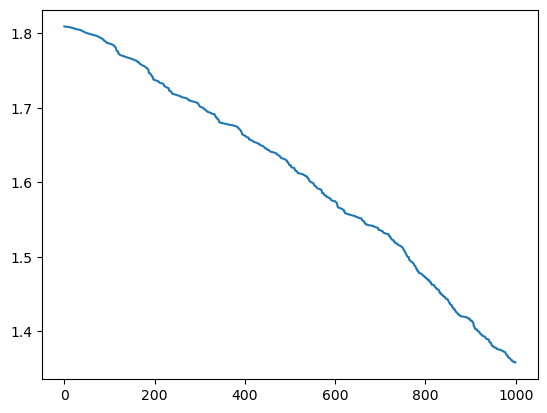

In [263]:
plt.plot(ga.cost)

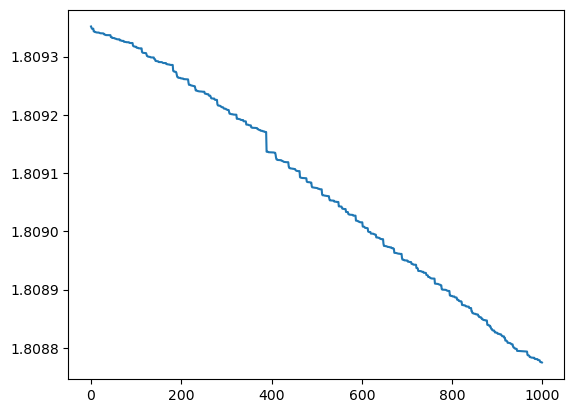

In [249]:
plt.plot(ga.cost)

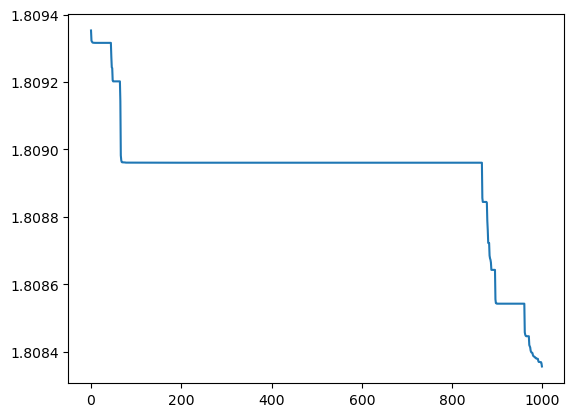

In [241]:
plt.plot(ga.cost)

In [242]:
ga.cost

[1.8093532437717945,
 1.8093228433193624,
 1.809320415104432,
 1.8093180037261227,
 1.8093170890730215,
 1.809317036692422,
 1.8093167224088258,
 1.8093165652670273,
 1.8093165446889348,
 1.8093164773424497,
 1.8093164773424497,
 1.8093164773424497,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.809275054495413,
 1.809243873302196,
 1.8092413172033965,
 1.8092050845504954,
 1.8092022003294723,
 1.8092022003294723,

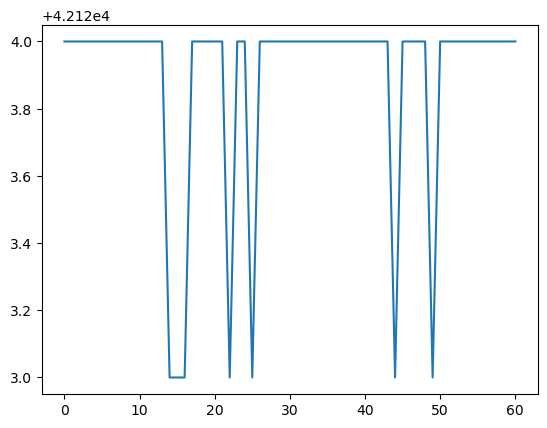

In [81]:
plt.plot(ga.children_sampled)

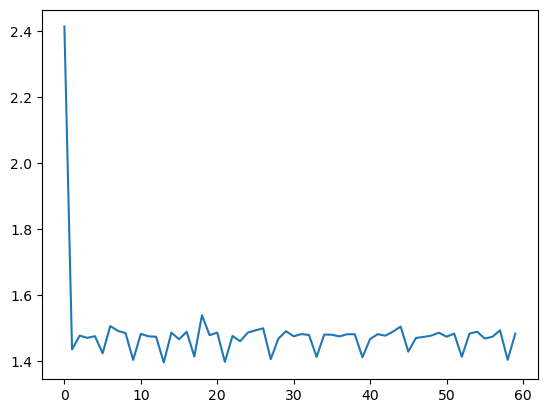

In [82]:
plt.plot(ga.time_model)

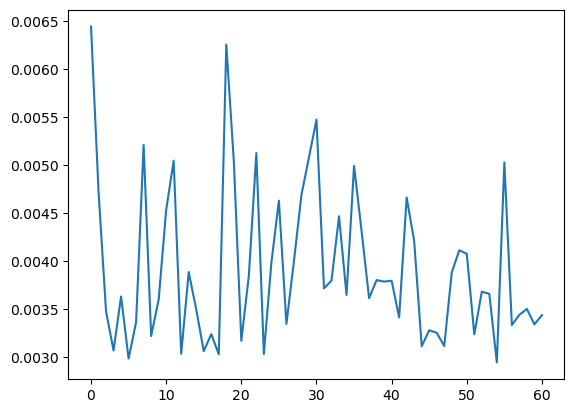

In [83]:
plt.plot(ga.time_child)